<script src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>

<div style="text-align: left;">
    <h1>Uber Versus Public Transit</h1>
    <h2>Final Project</h2>
    <h4>ECON 434 - Machine Learning and Big Data for Economists</h3>
    <div style="padding: 20px 0;">
        <hr style="border: 0; height: 1px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(0, 0, 0, 0.75), rgba(0, 0, 0, 0));">
        <p><em>Luis-Alejandro Samayoa-Alvarado</em><br>
        <p><em>Mauricio Vargas-Estrada</em><br>
        <p><em>Nikolaos Papadatos</em><br>
        <p><em>William Borelli Ebert</em><br>
        <p>Master of Quantitative Economics<br>
        University of California - Los Angeles</p>
        <hr style="border: 0; height: 1px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(0, 0, 0, 0.75), rgba(0, 0, 0, 0));">
    </div>
</div>

In this project, we study whether Uber complements (helps) or substitutes (hurts) public transit. On the one hand, Uber can substitute public transit if riders decide to choose Uber instead of public transit. On the other hand, Uber can complement public transit if riders take Uber from home to public transit stop, which can make public transit more attractive than driving a car. The net effect is unclear and is a subject of intense policy debate.

We will expand on the original set of results presented in Hall, Palsson, and Price (2018), “Is Uber a substitute or a complement for public transit,” *Journal of Urban Economics*, which is available on the class website. We will use their dataset, which is also available on the class website. In the dataset, a unit of ob- servation is a public transit agency in a given year-month. The dataset includes information on both the transit agencies and on the Metropolitan Statistical Areas (MSA) where they operate. For each time period, the dataset contains values for the following variables:

1. $UPTTotal$ – the number of rides for the public transit agency;
2. $treatUberX$ - a dummy for Uber presence in the corresponding MSA;
3. $treatGTNotStd$ - a variable measuring google search intensity for Uber in the corresponding MSA;
4. $popestimate$ - population in the corresponding MSA;
5. $employment$ - employment in the corresponding MSA;
6. $aveFareTotal$ - average fare for the public transit agency;
7. $VRHTTotal$ - vehicle hours for the public transit agency;
8. $VOMSTotal$ - number of vehicles employed by the public transit agency;
9. $VRMTotal$ - vehicle miles for the public transit agency;
10. $gasPrice$ - gas price in the corresponding MSA.

In this dataset, $treatUberX$ and $treatGTNotStd$ is qualitative and quantitative measures for the same thing: Uber presence in the MSA. We can run regressions using either of these two variables and then check whether results are robust if the other variable is used.

There are two variations in this dataset that allow us to study the effect of Uber on public transit. First, in any given time period, Uber is present in some MSAs but not others. We can thus study the effect of Uber by comparing these MSAs. Second, for any given MSA, we have data on time periods both before and after Uber was introduced in this MSA. We can thus study the effect of Uber by comparing these time periods. By working with panel data, we are able to employ both variations at the same time.

To study the effect of Uber on public transit, we let $Y_{it}$ be $UPTTotal$, $D_{it}$ be either $treatUberX$ or $treatGTNotStd$, and $W_{it}$ be the vector including remaining variables: $popestimate$, $employment$, $aveFareTotal$, $VRHTTotal$, $VOMSTotal$, $VRMTotal$, $gasPrice$. We then run the following regressions:

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

from scipy.stats import norm
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from linearmodels.panel import PanelOLS

from src.BCCH import BCCH
from src.double_lasso import double_lasso
from src.double_lasso_OLS import double_lasso_OLS

In [23]:
# Load data
data = pd.read_csv("data/uber_dataset.csv", index_col=0)

# Drop treatGTNotStd variable
data = data.drop(columns="treatGTNotStd")

# Drop rows with missing values
data = data.dropna()

# If treatUberX is greater than 0.5, set it to 1, if not, set it to 0
data["treatUberX"] = (data["treatUberX"] > 0.5).astype(int)

# Create interaction between agency and city
data["agency_city"] = data["agency"] + data["city"]

# Calculate the median population
data_copy = data[["UPTTotal", "popestimate", "city"]].copy()
p = data_copy.groupby(["city"]).median()
median_population = p["popestimate"].median()

# Create the dummy variable P_{it}
data["P"] = (data["popestimate"] > median_population).astype(int)

# Calculate the median rides
median_rides = p["UPTTotal"].median()

# Create the dummy variable F_{it}
data["F"] = (data["UPTTotal"] > median_rides).astype(int)

# Create the interaction term P_{it} * D_{it}
data["PxD"] = data["P"] * data["treatUberX"]

# Create the interaction term F_{it} * D_{it}
data["FxD"] = data["F"] * data["treatUberX"]

In line with the approach proposed by Hall, Palsson, and Price (2018), logarithmic transformations were applied to the set of control variables. The variables considered were the average fare, the maximum number of vehicles in operation within the month, vehicle-hours of service, vehicle-miles of service, regional gas prices, employment statistic, and population size. The motivation is linked to the fluctuation of magnitudes in the control variables, reducing the impact of possible outlier impact, and handle the skewness of distributions.

<div style="border: 1px solid black; border-radius: 5px; overflow: hidden;">
    <div style="background-color: black; color: white; padding: 5px; text-align: left;">
        1.)
    </div>
    <div style="padding: 10px;">
        OLS: log \(Y_{it} = \alpha + D_{it} \beta + W_{it}' \gamma + \epsilon_{it}\).
    </div>
</div>

In [24]:
# Convert 'dateSurvey' to datetime format
data["dateSurvey"] = pd.to_datetime(data["dateSurvey"], errors="coerce")

# Set the index to be a MultiIndex for panel data
data = data.set_index(["agency_city", "dateSurvey"])

# Define the dependent variable and independent variables
Y = np.log(data["UPTTotal"])
D = data["treatUberX"]
W = data[
    [
        "popestimate",
        "employment",
        "aveFareTotal",
        "VRHTotal",
        "VOMSTotal",
        "VRMTotal",
        "gasPrice",
    ]
]
PxD = data["PxD"]
FxD = data["FxD"]

# Scale the independent variables with log transformation
W_scaled_df = np.log(W)

# Create the design matrices
X = pd.concat([D, W_scaled_df], axis=1)

# Add constant to the models
X = sm.add_constant(X)

In [25]:
# Fit the OLS model
model1 = sm.OLS(Y, X).fit()

# Print the results
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               UPTTotal   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                 4.463e+04
Date:                Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                        19:27:17   Log-Likelihood:                -84548.
No. Observations:               71768   AIC:                         1.691e+05
Df Residuals:                   71759   BIC:                         1.692e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.7976      0.068    -11.676   

This regression gives us an initial estimation of the effects of Uber presence on public transit ridership, showing a 3.82% increase in ridership, suggesting that Uber complements public transit. Higher population estimates are associated with a decrease in ridership, while higher employment levels are linked to a significant increase. Higher average fares negatively affect ridership, while more vehicle hours and miles significantly increase ridership. The results also suggest that more vehicles in service decrease ridership, and higher gas prices lead to a significant increase in ridership.

<div style="border: 1px solid black; border-radius: 5px; overflow: hidden;">
    <div style="background-color: black; color: white; padding: 5px; text-align: left;">
        2.)
    </div>
    <div style="padding: 10px;">
        OLS: log \(Y_{it} = \eta_i + \delta_t + D_{it} \beta + W_{it}' \gamma + \epsilon_{it}\).
    </div>
</div>

In [26]:
# Ensure Y is a Series rather than a DataFrame
Y = Y.squeeze()

# Create the design matrices
X = pd.concat([D, W_scaled_df], axis=1)

# Fit the Panel OLS models with individual and time fixed effects
model2 = PanelOLS(Y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
result2 = model2.fit()

# Print the summaries to check the fixed effects inclusion
print(result2.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               UPTTotal   R-squared:                        0.3295
Estimator:                   PanelOLS   R-squared (Between):              0.9395
No. Observations:               71768   R-squared (Within):               0.3476
Date:                Sat, Jun 08 2024   R-squared (Overall):              0.9503
Time:                        19:27:18   Log-likelihood                   -5543.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4357.3
Entities:                         676   P-value                           0.0000
Avg Obs:                       106.17   Distribution:                 F(8,70941)
Min Obs:                       6.0000                                           
Max Obs:                       144.00   F-statistic (robust):             4357.3
                            

To account for bias across agencies and within time, we use fixed effects. Using this model, we estimate a 3.54% decrease in ridership, suggesting that Uber substitutes public transit. Higher population estimates are associated with an increase in ridership, in contrast to the previous model, while higher employment levels are linked to an increase. Higher average fares negatively affect ridership, while more vehicle hours and miles significantly increase ridership. The results also suggest that more vehicles in service increase ridership, and, paradoxically, gas prices have a negative but significant effect, unlike in the first OLS model.

<div style="border: 1px solid black; border-radius: 5px; overflow: hidden;">
    <div style="background-color: black; color: white; padding: 5px; text-align: left;">
        3.)
    </div>
    <div style="padding: 10px;">
        OLS: log \(Y_{it} = \eta_i + \delta_t + D_{it} \beta_1 + D_{it} Pit_i \beta_2 + W_{it}' \gamma + \epsilon_{it}\), where \(Pit_i\) is a dummy that takes value 1 if the corresponding MSA has population larger than the median population in the dataset and 0 otherwise.
    </div>
</div>

In [27]:
# Create the design matrices
X1 = pd.concat([D, PxD, W], axis=1)

# Fit the Panel OLS models with individual and time fixed effects
model3 = PanelOLS(Y, X1, entity_effects=True, time_effects=True, drop_absorbed=True)
result3 = model3.fit()

print(result3.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               UPTTotal   R-squared:                        0.0103
Estimator:                   PanelOLS   R-squared (Between):              0.0023
No. Observations:               71768   R-squared (Within):              -0.0002
Date:                Sat, Jun 08 2024   R-squared (Overall):              0.0062
Time:                        19:27:19   Log-likelihood                -1.951e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      82.066
Entities:                         676   P-value                           0.0000
Avg Obs:                       106.17   Distribution:                 F(9,70940)
Min Obs:                       6.0000                                           
Max Obs:                       144.00   F-statistic (robust):             82.066
                            

We expand our analysis to examine how the effect of Uber differs based on the population of the MSA. We add $P_{it}$, a dummy variable that takes a value of 1 if the population is larger than the median population in the dataset and 0 otherwise. Using this model, we estimate a 0.75% increase in ridership, which is not statistically significant. Higher average fares negatively affect ridership, while more vehicle hours and miles seem to slightly increase ridership. The results also suggest that more vehicles in service significantly increase ridership, while more vehicle miles slightly decrease it. Again, gas prices do not have a significant effect in this model. Overall, we observe that the majority of the coefficients are very close to 0, with confidence intervals indicating that they could have either a positive or negative overall effect on ridership.

<div style="border: 1px solid black; border-radius: 5px; overflow: hidden;">
    <div style="background-color: black; color: white; padding: 5px; text-align: left;">
        4.)
    </div>
    <div style="padding: 10px;">
        OLS: log \(Y_{it} = \eta_i + \delta_t + D_{it} \beta_1 + D_{it} Fit_i \beta_2 + W_{it}' \gamma + \epsilon_{it}\), where \(Fit_i\) is a dummy that takes value 1 if the number of rides of the public travel agency is larger than the median number of rides among all public transit agencies in the dataset.
    </div>
</div>

In [28]:
# Create the design matrices
X2 = pd.concat([D, FxD, W], axis=1)

# Fit the Panel OLS models with individual and time fixed effects
model4 = PanelOLS(Y, X2, entity_effects=True, time_effects=True, drop_absorbed=True)
result4 = model4.fit()

print(result4.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               UPTTotal   R-squared:                        0.0102
Estimator:                   PanelOLS   R-squared (Between):             -0.0011
No. Observations:               71768   R-squared (Within):              -0.0011
Date:                Sat, Jun 08 2024   R-squared (Overall):              0.0029
Time:                        19:27:20   Log-likelihood                -1.952e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      81.376
Entities:                         676   P-value                           0.0000
Avg Obs:                       106.17   Distribution:                 F(9,70940)
Min Obs:                       6.0000                                           
Max Obs:                       144.00   F-statistic (robust):             81.376
                            

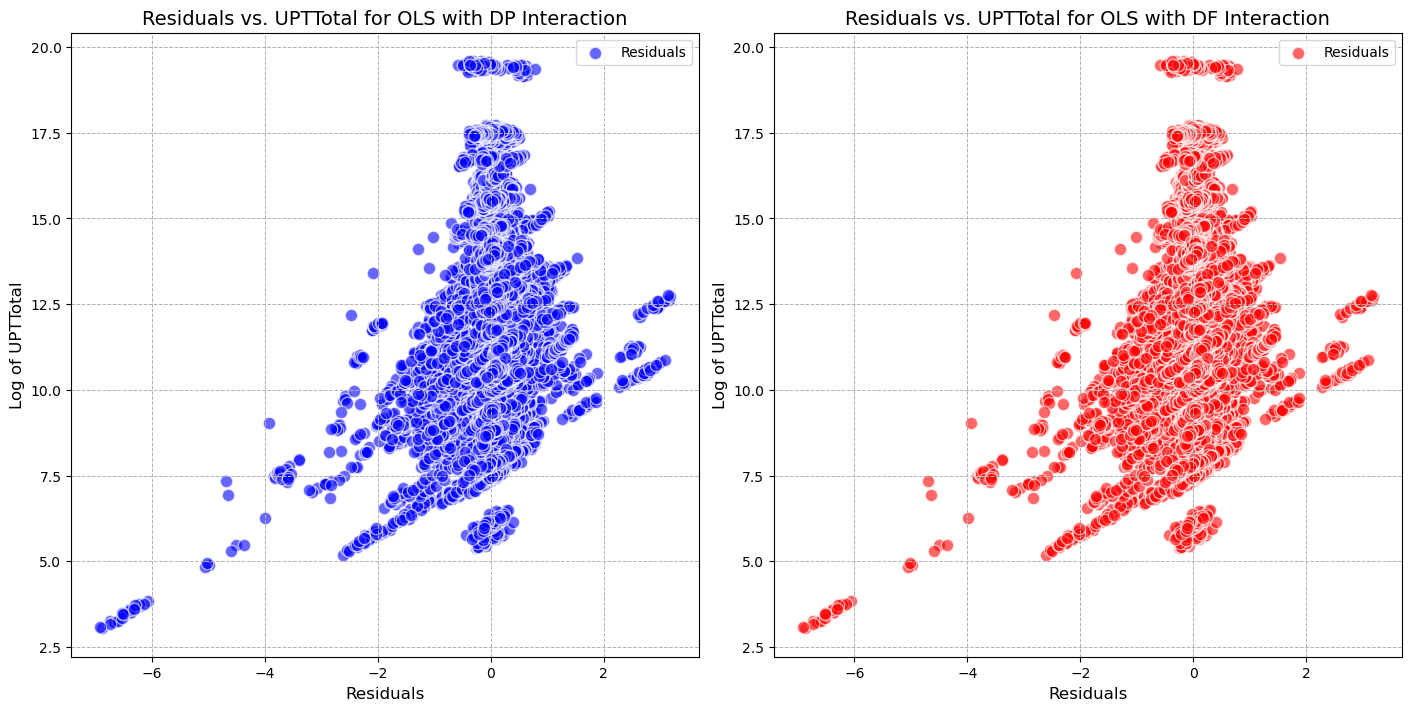

In [29]:
#Create Residuals
ols3_res= result3.resids
ols4_res = result4.resids

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), constrained_layout=True)

# First plot
axes[0].scatter(ols3_res, np.log(data['UPTTotal']), label='Residuals', 
                color='b', alpha=0.6, edgecolor='w', s=80)
axes[0].set_xlabel('Residuals', fontsize=12)
axes[0].set_ylabel('Log of UPTTotal', fontsize=12)
axes[0].set_title('Residuals vs. UPTTotal for OLS with DP Interaction', fontsize=14)
axes[0].legend()
axes[0].grid(True, which='both', linestyle='--', linewidth=0.7)

# Second plot
axes[1].scatter(ols4_res, np.log(data['UPTTotal']), label='Residuals', 
                color='r', alpha=0.6, edgecolor='w', s=80)
axes[1].set_xlabel('Residuals', fontsize=12)
axes[1].set_ylabel('Log of UPTTotal', fontsize=12)
axes[1].set_title('Residuals vs. UPTTotal for OLS with DF Interaction', fontsize=14)
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--', linewidth=0.7)

plt.show()

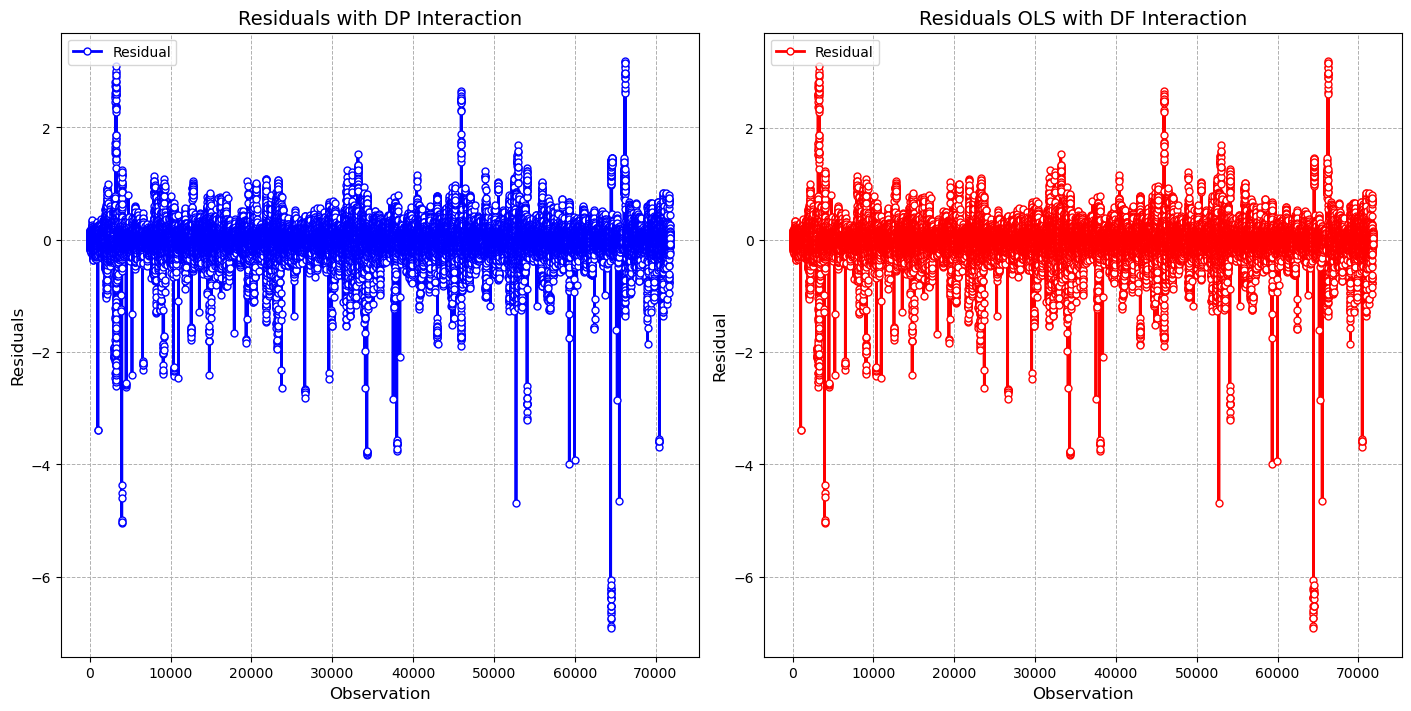

In [30]:
# Create Figure
obs_count = list(range(1, len(ols3_res) + 1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), constrained_layout=True)

# First plot
axes[0].plot(obs_count, ols3_res, label='Residual', color='b', linewidth=2, 
             marker='o', markersize=5, markerfacecolor='white')
axes[0].set_xlabel('Observation', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)
axes[0].set_title('Residuals with DP Interaction', fontsize=14)
axes[0].legend()
axes[0].grid(True, which='both', linestyle='--', linewidth=0.7)

# Second plot
axes[1].plot(obs_count, ols4_res, label='Residual', color='r', linewidth=2, 
             marker='o', markersize=5, markerfacecolor='white')
axes[1].set_xlabel('Observation', fontsize=12)
axes[1].set_ylabel('Residual', fontsize=12)
axes[1].set_title('Residuals OLS with DF Interaction', fontsize=14)
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--', linewidth=0.7)

plt.show()

Instead of examining how the effect of Uber differs based on the population, we now account for heterogeneity based on the number of riders using public transit before Uber arrived. We add $F_{it}$, a dummy variable that takes a value of 1 if the number of rides of the public transit agency is larger than the median number of rides among all public transit agencies in the dataset. Using this model, we estimate a 3.09% decrease in ridership, suggesting that Uber substitutes public transit. Apart from that important difference, the rest of the control variables are similar in both magnitude and sign to those observed in regression 3.

| Variable     | $OLS_1$ | $OLS_2$ | $OLS_3$    | $OLS_4$    |
| ------------ | ------- | ------- | ---------- | ---------- |
| Intercept    | -0.7976 | N/A     | N/A        | N/A        |
| treatUberX   | 0.0382  | -0.0354 | 0.0075     | -0.0309    |
| popestimate  | -0.9271 | 0.2789  | -9.98e-08  | -1.038e-07 |
| employment   | 0.9909  | 0.2677  | 1.769e-07  | 1.737e-07  |
| aveFareTotal | -0.1277 | -0.0996 | -0.0012    | -0.0012    |
| VRHTotal     | 1.3417  | 0.3052  | 8.564e-07  | 8.576e-07  |
| VOMSTotal    | -0.2376 | 0.2314  | 0.0005     | 0.0005     |
| VRMTotal     | 0.0688  | 0.2664  | -2.596e-08 | -2.602e-08 |
| gasPrice     | 0.2136  | -0.0407 | -0.0096    | -0.0101    |

Overall, the OLS models indicate that we cannot definitively determine whether the effect of Uber on public transit was complementary or supplementary. The results are not robust across regressions, and therefore, we cannot establish causality. This inconsistency suggests that further analysis with more rigorous methods is needed to understand the true impact of Uber on public transit ridership. Below, we try to address these problems using LASSO and double LASSO regression techniques.

<div style="border: 1px solid black; border-radius: 5px; overflow: hidden;">
    <div style="background-color: black; color: white; padding: 5px; text-align: left;">
        5.)
    </div>
    <div style="padding: 10px;">
        LASSO: log \(Y_{it} = \eta_i + \delta_t + D_{it} \beta_1 + D_{it} Pit \beta_2 + W_{it}' \gamma + \epsilon_{it}\).
    </div>
</div>

In [31]:
# Load data
data.reset_index(inplace=True)

# Define the dependent variable and independent variables
Y = np.log(data["UPTTotal"])
D = data["treatUberX"]
W = data[
    [
        "popestimate",
        "employment",
        "aveFareTotal",
        "VRHTotal",
        "VOMSTotal",
        "VRMTotal",
        "gasPrice",
    ]
]
PxD = data["PxD"]
FxD = data["FxD"]

# Scale the independent variables with log transformation
W_scaled_df = np.log(W)

# Create the design matrices
X = pd.concat([D, W_scaled_df], axis=1)

# Encode entity and time as dummy variables
entity_dummies = pd.get_dummies(data["agency_city"], drop_first=True)
time_dummies = pd.get_dummies(data["dateSurvey"], drop_first=True)

# Create the design matrices
X3 = np.column_stack((D, PxD, W_scaled_df, entity_dummies, time_dummies))
Y = np.log(data["UPTTotal"])

In [32]:
# Fit Lasso regression models
alpha1 = BCCH(X3, Y)
lasso1 = Lasso(alpha=alpha1)  # You can adjust the alpha parameter as needed
lasso1.fit(X3, Y)

# Define the feature names
feature_names = [
    "D",
    "P",
    "popestimate",
    "employment",
    "aveFareTotal",
    "VRHTotal",
    "VOMSTotal",
    "VRMTotal",
    "gasPrice",
]

# Create DataFrame for Model 1
coef1_df = pd.DataFrame({"Feature": feature_names, "Coefficient": lasso1.coef_[:9]})

print("Model 1 Coefficients:")
print(coef1_df)

Model 1 Coefficients:
        Feature  Coefficient
0             D     0.000000
1             P     0.000000
2   popestimate     0.000000
3    employment     0.009711
4  aveFareTotal    -0.000000
5      VRHTotal     1.170157
6     VOMSTotal     0.000000
7      VRMTotal     0.000000
8      gasPrice     0.000000


We are running a LASSO regression to understand which of the covariates in the dataset are the most relevant predictors of public transit ridership. This model includes \(P_{it}\), a dummy variable that conditions on whether the population is larger than the median population in the dataset. The coefficients for Uber presence (D) and population (P) are both zero, suggesting they do not significantly affect ridership in this context. Employment and vehicle hours appear to be the only significant predictors, both contributing positively to ridership.

<div style="border: 1px solid black; border-radius: 5px; overflow: hidden;">
    <div style="background-color: black; color: white; padding: 5px; text-align: left;">
        6.)
    </div>
    <div style="padding: 10px;">
        LASSO: log \(Y_{it} = \eta_i + \delta_t + D_{it} \beta_1 + D_{it} Fit \beta_2 + W_{it}' \gamma + \epsilon_{it}\).
    </div>
</div>

In [33]:
# Create the design matrices
X4 = np.column_stack((D, FxD, W_scaled_df, entity_dummies, time_dummies))

# Fit Lasso regression models
alpha2 = BCCH(X4, Y)
lasso2 = Lasso(alpha=alpha1)  # You can adjust the alpha parameter as needed
lasso2.fit(X4, Y)

# Define the feature names
feature_names = [
    "D",
    "F",
    "popestimate",
    "employment",
    "aveFareTotal",
    "VRHTotal",
    "VOMSTotal",
    "VRMTotal",
    "gasPrice",
]

# Create DataFrame for Model 1
coef2_df = pd.DataFrame({"Feature": feature_names, "Coefficient": lasso2.coef_[:9]})

print("Model 2 Coefficients:")
print(coef2_df)

Model 2 Coefficients:
        Feature  Coefficient
0             D     0.000000
1             F     0.000000
2   popestimate     0.000000
3    employment     0.009711
4  aveFareTotal    -0.000000
5      VRHTotal     1.170157
6     VOMSTotal     0.000000
7      VRMTotal     0.000000
8      gasPrice     0.000000


This model includes $F_{it}, a dummy variable that conditions on whether the number of rides of the public transit agency is larger than the median number of rides among all public transit agencies before Uber was introduced. The coefficients for Uber presence (D) and the number of riders before Uber (F) are, again, zero, suggesting they do not significantly affect ridership in this context. As in the previous model, employment and vehicle hours appear to be the only significant predictors, both contributing positively to ridership. 

We observe that in both regressions, the non-zero coefficients are the same and identical in magnitude. Two factors contribute to this observation. Firstly, in both regressions, the penalty parameter calculated by the BCHH is identical. Secondly, despite having different treatments, we identify the same subset of variables as important. These factors also lead to the result that the treatments are disregarded, allowing us to conclude that they are not significant predictors of public transit ridership.

| Variable     | $LASSO_5$ | $LASSO_6$ |
| ------------ | --------- | --------- |
| D            | 0         | 0         |
| DP           | 0         | N/A       |
| DF           | N/A       | 0         |
| popestimate  | 0         | 0         |
| employment   | 0.009711  | 0.009711  |
| aveFareTotal | 0         | 0         |
| VRHTotal     | 1.170157  | 1.170157  |
| VOMSTotal    | 0         | 0         |
| VRMTotal     | 0         | 0         |
| gasPrice     | 0         | 0         |

<div style="border: 1px solid black; border-radius: 5px; overflow: hidden;">
    <div style="background-color: black; color: white; padding: 5px; text-align: left;">
        7.)
    </div>
    <div style="padding: 10px;">
        Double-LASSO: log \(Y_{it} = \eta_i + \delta_t + D_{it} \beta_1 + D_{it} Pit \beta_2 + \tilde{W}_{it}' \gamma + \epsilon_{it}\), where coefficients of interest are \(\beta_1\) and \(\beta_2\).
    </div>
</div>

In [34]:
Y = np.array(np.log(data["UPTTotal"]), ndmin=1).T
D = np.array(data["treatUberX"], ndmin=1).T
W = np.array(
    np.log(
        data[
            [
                "popestimate",
                "employment",
                "aveFareTotal",
                "VRHTotal",
                "VOMSTotal",
                "VRMTotal",
                "gasPrice",
            ]
        ]
    )
)
P = np.array(data["P"], ndmin=1).T
W1 = np.column_stack((D * P, W))
W2 = np.column_stack((D, W))
DP = D * P

# Convert dummy variables to numpy arrays
entity_dummies_array = entity_dummies.to_numpy()
time_dummies_array = time_dummies.to_numpy()

# Concatenate the arrays
W1_combined = np.concatenate([W1, entity_dummies_array, time_dummies_array], axis=1)
W2_combined = np.concatenate([W2, entity_dummies_array, time_dummies_array], axis=1)


# Run double LASSO regression to estimate alpha for D
estimated_beta_1, estimated_std_error = double_lasso(Y, D, W1_combined)
print("Estimated beta_1:", estimated_beta_1.round(4))
print("Estimated standard error:", estimated_std_error.round(4))
min = estimated_beta_1 - 1.96 * estimated_std_error
max = estimated_beta_1 + 1.96 * estimated_std_error
print("Confidence interval:", (min.round(4), max.round(4)))

Estimated beta_1: 0.1249
Estimated standard error: 0.0335
Confidence interval: (0.0592, 0.1906)


In [35]:
# Run double LASSO regression to estimate alpha for D*P
estimated_beta_2, estimated_std_error = double_lasso(Y, DP, W2_combined)
print("Estimated beta_2:", estimated_beta_2.round(4))
print("Estimated standard error:", estimated_std_error.round(4))
min = estimated_beta_2 - 1.96 * estimated_std_error
max = estimated_beta_2 + 1.96 * estimated_std_error
print("Confidence interval:", (min.round(4), max.round(4)))

Estimated beta_2: -0.0963
Estimated standard error: 0.0375
Confidence interval: (-0.1698, -0.0229)


In this model, $beta_1$ is estimated to be 0.1249 with a standard error of 0.0335. The confidence interval for $beta_1$ is (0.0592, 0.1906), indicating that the effect of Uber presence ($D_{it}$) on public transit ridership is positive and statistically significant. This suggests that Uber presence alone is associated with an increase in ridership, indicating that Uber complements public transit.

Additionally, $beta_2$ is estimated to be -0.0963 with a standard error of 0.0375. The confidence interval for $beta_2$ is (-0.1698, -0.0229), indicating that the interaction effect of having a population above the median and Uber presence ($P_{it} \times D_{it}$) on public transit ridership is negative and statistically significant. This suggests that in areas with a population above the median, Uber presence is associated with a 10% decrease in ridership compared to areas with below-median populations, indicating that Uber substitutes public transit in more populous areas.

<div style="border: 1px solid black; border-radius: 5px; overflow: hidden;">
    <div style="background-color: black; color: white; padding: 5px; text-align: left;">
        8.)
    </div>
    <div style="padding: 10px;">
        Double-LASSO: log \(Y_{it} = \eta_i + \delta_t + D_{it} \beta_1 + D_{it} Fit \beta_2 + \tilde{W}_{it}' \gamma + \epsilon_{it}\), where coefficients of interest are \(\beta_1\) and \(\beta_2\).
    </div>
</div>

In [36]:
F = np.array(data["F"], ndmin=1).T
W3 = np.column_stack((D * F, W))
W3_combined = np.concatenate([W3, entity_dummies_array, time_dummies_array], axis=1)
DF = D * F

# Run double LASSO regression to estimate alpha for D, using F as an instrument
estimated_beta_1, estimated_std_error = double_lasso(Y, D, W3_combined)
print("Estimated beta_1:", estimated_beta_1.round(4))
print("Estimated standard error:", estimated_std_error.round(4))
min = estimated_beta_1 - 1.96 * estimated_std_error
max = estimated_beta_1 + 1.96 * estimated_std_error
print("Confidence interval:", (min.round(4), max.round(4)))

Estimated beta_1: -0.2374
Estimated standard error: 0.0188
Confidence interval: (-0.2743, -0.2006)


In [37]:
# Run double LASSO regression to estimate alpha for D*F
estimated_beta_2, estimated_std_error = double_lasso(Y, DF, W2_combined)
print("Estimated beta_2:", estimated_beta_2.round(4))
print("Estimated standard error:", estimated_std_error.round(4))
min = estimated_beta_2 - 1.96 * estimated_std_error
max = estimated_beta_2 + 1.96 * estimated_std_error
print("Confidence interval:", (min.round(4), max.round(4)))

Estimated beta_2: 0.5964
Estimated standard error: 0.0224
Confidence interval: (0.5525, 0.6403)


In this model, $beta_1$ is estimated to be -0.2374 with a standard error of 0.0188. The confidence interval for $beta_1$ is (-0.2743, -0.2006), indicating that the effect of Uber presence ($D_{it}$) on public transit ridership is negative and statistically significant. This suggests that Uber presence alone is associated with a decrease in ridership, indicating that Uber substitutes public transit.

Additionally, $beta_2$ is estimated to be 0.5964 with a standard error of 0.0224. The confidence interval for $beta_2$ is (0.5525, 0.6403), indicating that the interaction effect of having a number of riders above the median and Uber presence ($F_{it} \times D_{it}$) on public transit ridership is positive and statistically significant. This suggests that in areas with a number of riders above the median, Uber presence is associated with a 60% increase in ridership compared to areas with below-median ridership, indicating that Uber complements public transit in areas with higher initial ridership.

| Variable | $Double\,Lasso_7$ | $Double\,Lasso_8$ |
| -------- | ----------------- | ----------------- |
| D        | 0.1249            | -0.2374           |
| D lower  | 0.0592            | -0.2743           |
| D upper  | 0.1906            | -0.2006           |
| PD       | -0.0963           | N/A               |
| PD lower | -0.1698           | N/A               |
| PD upper | -0.0229           | N/A               |
| DF       | N/A               | 0.5964            |
| DF lower | N/A               | 0.5525            |
| DF upper | N/A               | 0.6403            |

<div style="border: 1px solid black; border-radius: 5px; overflow: hidden;">
    <div style="background-color: black; color: white; padding: 5px; text-align: left;">
        9.)
    </div>
    <div style="padding: 10px;">
        LASSO: log \(Y_{it} = \eta_i + \delta_t + D_{it} \beta_1 + D_{it} Pit \beta_2 + \tilde{W}_{it}' \gamma + \epsilon_{it}\), where \(\tilde{W}_{it}\) includes all interactions of order 5 of variables in the vector \(W_{it}\).
    </div>
</div>

In [38]:
# Create polynomial features of 5th order
poly = PolynomialFeatures(degree=5)
W_poly = poly.fit_transform(W_scaled_df)
W_p = pd.DataFrame(W_poly)
W_p.drop(columns=0, inplace=True)

In [39]:
# Create the design matrices
X9 = np.column_stack((D, PxD, W_p, entity_dummies, time_dummies))

# Fit Lasso regression models
alpha3 = BCCH(X9, Y)
lasso9 = Lasso(alpha=alpha3)  # You can adjust the alpha parameter as needed
lasso9.fit(X9, Y)

# Define the feature names
feature_names = [
    "D",
    "PD",
    "popestimate",
    "employment",
    "aveFareTotal",
    "VRHTotal",
    "VOMSTotal",
    "VRMTotal",
    "gasPrice",
]

# Create DataFrame for Model 9
coef9_df = pd.DataFrame({"Feature": feature_names, "Coefficient": lasso9.coef_[:9]})

print("Model 9 Coefficients:")
print(coef9_df)

Model 9 Coefficients:
        Feature  Coefficient
0             D         -0.0
1            PD         -0.0
2   popestimate         -0.0
3    employment         -0.0
4  aveFareTotal         -0.0
5      VRHTotal          0.0
6     VOMSTotal          0.0
7      VRMTotal          0.0
8      gasPrice          0.0


<div style="border: 1px solid black; border-radius: 5px; overflow: hidden;">
    <div style="background-color: black; color: white; padding: 5px; text-align: left;">
        10.)
    </div>
    <div style="padding: 10px;">
        LASSO: log \(Y_{it} = \eta_i + \delta_t + D_{it} \beta_1 + D_{it} Fit \beta_2 + \tilde{W}_{it}' \gamma + \epsilon_{it}\), where \(\tilde{W}_{it}\) includes all interactions of order 5 of variables in the vector \(W_{it}\).
    </div>
</div>

In [40]:
# Create the design matrices
X10 = np.column_stack((D, FxD, W_p, entity_dummies, time_dummies))

# Fit Lasso regression models
alpha4 = BCCH(X10, Y)
lasso10 = Lasso(alpha=alpha4)  # You can adjust the alpha parameter as needed
lasso10.fit(X10, Y)

# Define the feature names
feature_names = [
    "D",
    "FD",
    "popestimate",
    "employment",
    "aveFareTotal",
    "VRHTotal",
    "VOMSTotal",
    "VRMTotal",
    "gasPrice",
]

# Create DataFrame for Model 10
coef10_df = pd.DataFrame({"Feature": feature_names, "Coefficient": lasso10.coef_[:9]})

print("Model 10 Coefficients:")
print(coef10_df)

Model 10 Coefficients:
        Feature  Coefficient
0             D         -0.0
1            FD          0.0
2   popestimate         -0.0
3    employment         -0.0
4  aveFareTotal         -0.0
5      VRHTotal          0.0
6     VOMSTotal          0.0
7      VRMTotal          0.0
8      gasPrice          0.0


In both regressions, LASSO penalized all variables, shrinking their coefficients to zero. This outcome suggests that none of the variables, nor their interactions up to the fifth order, are strong predictors of public transit ridership when considering Uber presence and the interaction terms ($P_{it} \times D_{it}$ and $F_{it} \times D_{it}$). The complexity added by considering high-order interactions among the control variables does not enhance the model's ability to predict public transit ridership.

Given that neither Uber presence nor the high-order interactions of the control variables contribute significantly to the model, we can infer that the direct impact of Uber on public transit ridership, as captured by these models, is minimal. This conclusion aligns with the results from previously estimated, simpler models.

| Variable     | $LASSO_5$ | $LASSO_6$ | $LASSO_9$ | $LASSO_{10}$ |
| ------------ | --------- | --------- | --------- | ------------ |
| D            | 0         | 0         | 0         | 0            |
| DP           | 0         | N/A       | 0         | 0            |
| DF           | N/A       | 0         | 0         | 0            |
| popestimate  | 0         | 0         | 0         | 0            |
| employment   | 0.009711  | 0.009711  | 0         | 0            |
| aveFareTotal | 0         | 0         | 0         | 0            |
| VRHTotal     | 1.170157  | 1.170157  | 0         | 0            |
| VOMSTotal    | 0         | 0         | 0         | 0            |
| VRMTotal     | 0         | 0         | 0         | 0            |
| gasPrice     | 0         | 0         | 0         | 0            |

<div style="border: 1px solid black; border-radius: 5px; overflow: hidden;">
    <div style="background-color: black; color: white; padding: 5px; text-align: left;">
        11.)
    </div>
    <div style="padding: 10px;">
        Double-LASSO: log \(Y_{it} = \eta_i + \delta_t + D_{it} \beta_1 + D_{it} Pit \beta_2 + \tilde{W}_{it}' \gamma + \epsilon_{it}\), where coefficients of interest are \(\beta_1\) and \(\beta_2\) and \(\tilde{W}_{it}\) includes all interactions of order 5 of variables in the vector \(W_{it}\).
    </div>
</div>

In [41]:
Y = np.array(np.log(data["UPTTotal"]), ndmin=1).T
D = np.array(data["treatUberX"], ndmin=1).T
W = np.array(
    np.log(
        data[
            [
                "popestimate",
                "employment",
                "aveFareTotal",
                "VRHTotal",
                "VOMSTotal",
                "VRMTotal",
                "gasPrice",
            ]
        ]
    )
)
P = np.array(data["P"], ndmin=1).T
W1 = np.column_stack((D * P, W_p))
W2 = np.column_stack((D, W_p))
DP = D * P

# Convert dummy variables to numpy arrays
entity_dummies_array = entity_dummies.to_numpy()
time_dummies_array = time_dummies.to_numpy()

# Concatenate the arrays
W1_combined = np.concatenate([W1, entity_dummies_array, time_dummies_array], axis=1)
W2_combined = np.concatenate([W2, entity_dummies_array, time_dummies_array], axis=1)


# Run double LASSO regression to estimate alpha for D
estimated_beta_1, estimated_std_error = double_lasso(Y, D, W1_combined)
print("Estimated beta_1:", estimated_beta_1.round(4))
print("Estimated standard error:", estimated_std_error.round(4))
min = estimated_beta_1 - 1.96 * estimated_std_error
max = estimated_beta_1 + 1.96 * estimated_std_error
print("Confidence interval:", (min.round(4), max.round(4)))

Estimated beta_1: 0.0254
Estimated standard error: 0.0137
Confidence interval: (-0.0015, 0.0523)


In [42]:
# Run double LASSO regression to estimate alpha for D*P
estimated_beta_2, estimated_std_error = double_lasso(Y, DP, W2_combined)
print("Estimated beta_2:", estimated_beta_2.round(4))
print("Estimated standard error:", estimated_std_error.round(4))
min = estimated_beta_2 - 1.96 * estimated_std_error
max = estimated_beta_2 + 1.96 * estimated_std_error
print("Confidence interval:", (min.round(4), max.round(4)))

Estimated beta_2: -0.0092
Estimated standard error: 0.0142
Confidence interval: (-0.0371, 0.0187)


In this model, $\beta_1$ is estimated to be 0.0254 with a standard error of 0.0137. The confidence interval for $\beta_1$ is (-0.0015, 0.0523), indicating that the effect of Uber presence ($D_{it}$) on public transit ridership is not statistically significant. This suggests that Uber presence alone does not have a significant impact on ridership.

Additionally, $\beta_2$ is estimated to be -0.0092 with a standard error of 0.0142. The confidence interval for $\beta_2$ is (-0.0371, 0.0187), indicating that the interaction effect of having a population above the median and Uber presence ($P_{it} \times D_{it}$) on public transit ridership is also not statistically significant. This suggests that in areas with a population above the median, Uber presence does not significantly affect ridership.

<div style="border: 1px solid black; border-radius: 5px; overflow: hidden;">
    <div style="background-color: black; color: white; padding: 5px; text-align: left;">
        12.)
    </div>
    <div style="padding: 10px;">
        Double-LASSO: log \(Y_{it} = \eta_i + \delta_t + D_{it} \beta_1 + D_{it} Fit \beta_2 + \tilde{W}_{it}' \gamma + \epsilon_{it}\), where coefficients of interest are \(\beta_1\) and \(\beta_2\) and \(\tilde{W}_{it}\) includes all interactions of order 5 of variables in the vector \(W_{it}\).
    </div>
</div>

In [43]:
# Create Fit
F = np.array(data["F"], ndmin=1).T
W3 = np.column_stack((D * F, W_p))
DF = D * F

# Convert dummy variables to numpy arrays
entity_dummies_array = entity_dummies.to_numpy()
time_dummies_array = time_dummies.to_numpy()

# Concatenate the arrays
W3_combined = np.concatenate([W3, entity_dummies_array, time_dummies_array], axis=1)

# Run double LASSO regression to estimate alpha for D
estimated_beta_1, estimated_std_error = double_lasso(Y, D, W3_combined)
print("Estimated beta_1:", estimated_beta_1.round(4))
print("Estimated standard error:", estimated_std_error.round(4))
min = estimated_beta_1 - 1.96 * estimated_std_error
max = estimated_beta_1 + 1.96 * estimated_std_error
print("Confidence interval:", (min.round(4), max.round(4)))

Estimated beta_1: 0.0254
Estimated standard error: 0.0137
Confidence interval: (-0.0015, 0.0523)


In [44]:
# Run double LASSO regression to estimate alpha for D*F
estimated_beta_2, estimated_std_error = double_lasso(Y, DF, W2_combined)
print("Estimated beta_2:", estimated_beta_2.round(4))
print("Estimated standard error:", estimated_std_error.round(4))
min = estimated_beta_2 - 1.96 * estimated_std_error
max = estimated_beta_2 + 1.96 * estimated_std_error
print("Confidence interval:", (min.round(4), max.round(4)))

Estimated beta_2: 0.5033
Estimated standard error: 0.0157
Confidence interval: (0.4725, 0.534)


In this model, $\beta_1$ is also estimated to be 0.0254 with a standard error of 0.0137. The confidence interval for $\beta_1$ is (-0.0015, 0.0523), indicating that the effect of Uber presence ($D_{it}$) on public transit ridership is not statistically significant. This suggests that Uber presence alone does not have a significant impact on ridership.

Additionally, $\beta_2$ is estimated to be 0.5033 with a standard error of 0.0157. The confidence interval for $\beta_2$ is (0.4725, 0.5340), indicating that the interaction effect of having a number of riders above the median and Uber presence ($F_{it} \times D_{it}$) on public transit ridership is positive and statistically significant. This suggests that in areas with a higher number of initial riders, Uber presence is associated with a 50% increase in ridership compared to areas with below-median ridership, indicating that Uber complements public transit in areas with higher initial ridership. This result is similar to the one observed in Double-LASSO Regression 2, where we estimated this effect to be 60%.

Finally, we observe that the coefficients for $\beta_1$ from regressions 11 and 12 are identical. This phenomenon can be attributed to the inclusion of the polynomials which results to an exponential increase in the number of features included in the model. This approach adresses the issues of non linearities in the model and provides a robust estimation for the effect of Uber, which remains unaffected by change in the interaction effect fitted.s

| Variable | $Double\,Lasso_7$ | $Double\,Lasso_8$ | $Double\,Lasso_{11}$ | $Double\,Lasso_{12}$ |
| -------- | ----------------- | ----------------- | -------------------- | -------------------- |
| D        | 0.1249            | -0.2374           | 0.0254               | 0.0254               |
| D lower  | 0.0592            | -0.2743           | -0.0015              | -0.0015              |
| D upper  | 0.1906            | -0.2006           | 0.0523               | 0.0523               |
| PD       | -0.0963           | N/A               | -0.0092              | N/A                  |
| PD lower | -0.1698           | N/A               | -0.0371              | N/A                  |
| PD upper | -0.0229           | N/A               | 0.0187               | N/A                  |
| DF       | N/A               | 0.5964            | N/A                  | 0.5033               |
| DF lower | N/A               | 0.5525            | N/A                  | 0.4725               |
| DF upper | N/A               | 0.6403            | N/A                  | 0.534                |

## Conclusion

The purpose of this study is to examine the causal effects of Uber presence on public transit ridership. The goal is to determine whether Uber can substitute for public transit, for example, if riders choose Uber instead of public transit, or whether it can complement public transit, for example, if riders take Uber from home to a public transit stop, thereby making public transit more attractive than driving a car.

We use three different approaches for this problem: OLS, Lasso, and Double Lasso, all of which include fixed effects for public transport agencies and time. Along with the Uber treatment, in each approach we also test interactions for population and pre-Uber public rides, as well as different control variables.

As mentioned in the relevant section, the OLS models indicate that we cannot definitively determine whether the effect of Uber on public transit was complementary or supplementary. In terms of causality, none of the coefficients can be directly interpreted in a causal form because of the endogeneity problem in the error term. This means there is no orthogonality between the error term and the treatment.

The purpose of using Lasso combined with the BCCH λ selection method is to leverage the oracle property of this method. This means we select the most important covariates explaining changes in the dependent variable. We observe that in all the Lasso regressions (5, 6, 9, 10) the Uber treatment is excluded, along with the interactions of this covariate we have included. This suggests an undefinable relationship between the treatment and public transit ridership. However, we can't make any causal conclusions due to the same orthogonality issue with the error terms, which is now exacerbated by the inclusion of Lasso-generated bias.

To address the issue of orthogonality with the error term, we apply Double Lasso. In the first setting $(Double\,Lasso_7, Double\,Lasso_8)$, we include only linear covariates, observing highly variable estimation of the Uber treatment. This variability is explained by the misspecification problem in the two Double Lasso regression stages. This happens because the quality of the Double Lasso also depends on the strength of the orthogonality between the error terms of the dependent and independent variables (ε) and the treatment effect and controls (ν) in the two stages of the method. This issue is addressed by including polynomial features to the 5th power of the control variables $(Double\,Lasso_{11}, Double\,Lasso_{12})$, recalling the function approximation property of Taylor Series expansions. By using this setting, we conclude that the Uber treatment is significantly positive and robust to the inclusion of interactions between the treatment and other covariates.